In [341]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j0, j1, i0, jvp
from scipy.special import jn_zeros
from scipy.integrate import quad
from scipy.integrate import dblquad
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

## Constants and math functions

In [ ]:
H = 6
R = 0.005

z = np.linspace(0, H, 80)
r = np.linspace(0, R, 80)

max_k = 50
max_n = 50

In [343]:
# T_nk_array = np.load(f"T_nk_array_steel_h{H}_r{R}.npy")
# T_nk_array

In [344]:
def find_beta_k_roots(max_k, R=1):
    j1_zeros = jn_zeros(1, max_k)
    roots = j1_zeros / R
    return roots

In [ ]:
mu = 0.3
alpha = 1.2e-5 

def a_k(k):
    return np.pi*(2 * k + 1) / 2

def lambda_n(n, H):
    return (np.pi * n) / H 

beta_k = find_beta_k_roots(max_k, R)

In [346]:
j0bk = np.empty(max_k)
for k in range(max_k):
    j0bk[k] = j0(beta_k[k])

In [347]:
ak = np.empty(max_k)
for k in range(0, max_k+1):
    ak[k-1] = a_k(k)

In [348]:
lambdan = np.empty(max_n)
for k in range(0, max_n+1):
    lambdan[k-1] = lambda_n(k, H)

## Solutions

### Function $T$ of temperature

The solution of the mathematical model of the heat conduction problem
$$
T(r, z)=\sum^\infty_0\frac{I_0(a_kr)}{I_0(a_kR)}f_ksin(a_kz)
$$
Where
$$ 
f_k=\int^H_0f(z)sin(a_kz)dz 
$$

In [ ]:
def f(z):
    return -z**2+H*z

def f_k(k, H):
    integrand = lambda z: f(z) * np.sin(ak[k-1] * z)
    integral = quad(integrand, 0, H)[0]
    return integral

In [350]:
f_k_array = np.empty(max_k)
for k in range(1, max_k+1):
    result = f_k(k, H)
    f_k_array[k-1] = result 

C:\Users\VELIKIY\AppData\Local\Temp\ipykernel_21360\2273304720.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = quad(integrand, 0, H)[0]
C:\Users\VELIKIY\AppData\Local\Temp\ipykernel_21360\2273304720.py:6: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = quad(integrand, 0, H)[0]


In [351]:
def T(r, z):
    sum = np.sum((f_k_array / i0(ak * R)) * i0(ak * r) * np.sin(ak * z))
    return (2 / H) * sum

$$
T_{nk}=\int^R_0J_0(\beta_kr)rdr\int^H_0T(r,z)cos(\lambda_nz)dz \\
\lambda_n=\frac{\pi n}{2},\ \ n=0,1,... \\
\beta_k \text{ - solutions of the equation: } J_0(\beta_kR)=0 
$$

In [352]:
def T_nk(n, k, T_func, R, H):
    """
    Возвращает двойной интеграл
        ∫_{r=0}^R ∫_{z=0}^H T(r,z) * j0(beta_k[k] * r) * r * cos(lambdan[n] * z) dz dr
    """
    # Функция для dblquad: первый аргумент — z, второй — r
    def integrand(z, r):
        return T_func(r, z) * j0bk[k-1] * r * np.cos(lambdan[n-1] * z)

    # dblquad ожидает порядок: dblquad(func, r_min, r_max, z_min_fun, z_max_fun)
    result, error = dblquad(integrand,
                            0,     # r от 0
                            R,     # до R
                            lambda r: 0,  # для каждого r, z от 0
                            lambda r: H)  # до H
    return result

In [353]:
# T_nk_array = np.empty((max_n, max_k))
# H_array = [6, 12]
# R_array = [0.005, 0.01]
# for h in H_array:
#     for r in R_array:
#         beta_k = find_beta_k_roots(max_k, r)
#         lambdan = np.empty(max_n)
#         for k in range(0, max_n+1):
#             lambdan[k-1] = lambda_n(k, h)
#         f_k_array = np.empty(max_k)
#         for k in range(1, max_k+1):
#             result = f_k(k, h)
#             f_k_array[k-1] = result 
#         for n in range(1, max_n+1):
#             for k in range(1, max_k+1):
#                 result = T_nk(n, k, T, r, h)
#                 print(n, k, result)
#                 T_nk_array[n-1, k-1] = result
#         with open(f"T_nk_array_steel_h{h}_r{r}.npy", 'wb') as file:
#             np.save(file, T_nk_array)

In [354]:
T_nk_array = np.empty((max_n, max_k))
for n in range(1, max_n+1):
    for k in range(1, max_k+1):
        result = T_nk(n, k, T, R, H)
        print(n, k, result)
        T_nk_array[n-1, k-1] = result

1 1 -1.3065726486775186e-18
1 2 9.744258115828543e-19
1 3 -8.04625335153704e-19
1 4 7.184533339229684e-19
1 5 -6.470191797565954e-19
1 6 5.805279742151131e-19
1 7 -5.442548337931038e-19
1 8 5.090348983141153e-19
1 9 -4.8458607141140985e-19
1 10 4.607892287502694e-19
1 11 -4.3277933865397713e-19
1 12 4.1839426032275733e-19
1 13 -4.064006039207306e-19
1 14 3.8298743745641753e-19
1 15 -3.762653743223833e-19
1 16 3.695988741261103e-19
1 17 -3.567060512158898e-19
1 18 3.493128594593153e-19
1 19 -3.3885911050104e-19
1 20 3.3096284080278763e-19
1 21 -3.1366797678677123e-19
1 22 3.1115550739086025e-19
1 23 -3.0811501358994035e-19
1 24 3.0167903785338875e-19
1 25 -2.927124677456323e-19
1 26 2.8506347599081317e-19
1 27 -2.794002501601135e-19
1 28 2.753711502755532e-19
1 29 -2.712066927350201e-19
1 30 2.6793509598611107e-19
1 31 -2.659561600125724e-19
1 32 2.6114894376282334e-19
1 33 -2.5491791620912776e-19
1 34 2.49942613800602e-19
1 35 -2.444675355073236e-19
1 36 2.470385041440784e-19
1 37 -2.4

c:\Users\VELIKIY\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\integrate\_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


2 1 -0.002362447009327915
2 2 0.0017603749771518097
2 3 -0.0014646822552479251
2 4 0.001280820593168552
2 5 -0.0011523977683998827
2 6 0.0010561893445453496
2 7 -0.0009806469153144886
2 8 0.0009192944439020513
2 9 -0.0008681818865070649
2 10 0.0008247448934316683
2 11 -0.0007872366326029172
2 12 0.0007544205405069463
2 13 -0.0007253934079771672
2 14 0.00069947807820705
2 15 -0.0006761555483523501
2 16 0.0006550204416968449
2 17 -0.0006357509023002213
2 18 0.0006180876977326835
2 19 -0.0006018193764029025
2 20 0.0005867715098671258
2 21 -0.0005727987546430068
2 22 0.0005597788998525301
2 23 -0.0005476083390901724
2 24 0.00053619858054375
2 25 -0.0005254735252654215
2 26 0.0005153673214528988
2 27 -0.0005058226560034301
2 28 0.0004967892183843818
2 29 -0.00048822324476167065
2 30 0.0004800856207010887
2 31 -0.00047234179641326534
2 32 0.00046496100172554636
2 33 -0.0004579157305629703
2 34 0.00045118130884337323
2 35 -0.00044473553029104055
2 36 0.00043855834790257494
2 37 -0.00043263161

KeyboardInterrupt: 

### Functions $u(r, z)$ and $w(r, z)$

In [ ]:
def u(r, z):
    sum_u = 0.0
    # Первый член (n=0)
    for k in range(1, max_k + 1):
        term1 = ((3 - mu) / beta_k[k-1]) * (j1(beta_k[k-1] * r) / j0(beta_k[k-1] * R)**2) * T_nk_array[0, k-1]
        sum_u += term1
    # Остальные члены
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            numerator = ((3 - mu) * beta_k[k-1]**2 + 4 * (1 - mu) * lambdan[n-1]**2)
            denominator = (beta_k[k-1]**2 + lambdan[n-1]**2) * beta_k[k-1]
            term2 = (j1(beta_k[k-1] * r) / j0(beta_k[k-1] * R)**2) * (numerator / denominator) * np.cos(lambdan[n-1] * z) * T_nk_array[n-1, k-1]
            sum_u += term2
    coeff = (4 * (1 + mu) * alpha) / ((1 - mu) * H * R**2)
    return coeff * sum_u

In [ ]:
def w(r, z):
    sum_w = 0.0
    # Первый член (n=0)
    for n in range(1, max_n + 1):
        sum_w += np.sin(lambdan[n-1] * z) * T_nk_array[n-1, 0]
    sum_w *= -1 * (4 * (1 + mu) * alpha) / ((1 - mu) * H * R**2)

    # Остальные члены
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            numerator = lambdan[n-1]
            denominator = beta_k[k-1]**2 + lambdan[n-1]**2
            term = (j0(beta_k[k-1] * r) / j0(beta_k[k-1] * R)**2) * (numerator / denominator) * np.sin(lambdan[n-1] * z) * T_nk_array[n-1, k-1]
            sum_w += term
    coeff = (4 * (1 + mu) * alpha) / ((1 - mu) * H * R**2)
    return coeff * sum_w

### Partial derivative $u(r, z)$

In [ ]:
def partial_u_r(r, z):
    sum_u_r = 0.0
    # Первый член
    for k in range(1, max_k + 1):
        term1 = ((3 - mu) / beta_k[k-1]) * (jvp(beta_k[k-1] * r, 1) / j0(beta_k[k-1] * R)**2) * T_nk_array[0, k-1]
        sum_u_r += term1
    # Остальные члены
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            numerator = ((3 - mu) * beta_k[k-1]**2 + 4 * (1 - mu) * lambdan[n-1]**2)
            denominator = (beta_k[k-1]**2 + lambdan[n-1]**2) * beta_k[k-1]
            term2 = (jvp(beta_k[k-1] * r, 1) / j0(beta_k[k-1] * R)**2) * (numerator / denominator) * np.cos(lambdan[n-1] * z) * T_nk_array[n-1, k-1]
            sum_u_r += term2
    coeff = (4 * (1 + mu) * alpha) / ((1 - mu) * H * R**2)
    return coeff * sum_u_r

In [ ]:
def partial_u_z(r, z):
    sum_u_z = 0.0
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            numerator = (3 - mu) * beta_k[k-1]**2 * lambdan[n-1] + 4 * (1 - mu) * lambdan[n-1]**3
            denominator = (beta_k[k-1]**2 + lambdan[n-1]**2) * beta_k[k-1]
            term = (j1(beta_k[k-1] * r) / j0(beta_k[k-1] * R)**2) * (numerator / denominator) * np.sin(lambdan[n-1] * z) * T_nk_array[n-1, k-1]
            sum_u_z += term
    coeff = (4 * (1 + mu) * alpha) / ((1 - mu) * H * R**2)
    return coeff * sum_u_z

### Partial derivative $w(r, z)$

In [ ]:
def partial_w_r(r, z):
    sum_w_r = 0.0
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            term = (j1(beta_k[k-1] * r) / j0(beta_k[k-1] * R)**2) * (lambdan[n-1] / (beta_k[k-1]**2 + lambdan[n-1]**2)) * np.sin(lambdan[n-1] * z) * T_nk_array[n-1, k-1]
            sum_w_r += term
    return (4 * (1 + mu) * alpha) / ((1 - mu) * H * R**2) * sum_w_r

In [ ]:
def partial_w_z(r, z):
    sum_w_z = 0.0
    # Первый член
    for n in range(1, max_n + 1):
        sum_w_z += lambdan[n-1] * np.cos(lambdan[n-1] * z) * T_nk_array[n-1, 0]
    sum_w_z *= - (4 * (1 + mu) * alpha) / ((1 - mu) * H * R**2)
    # Остальные члены
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            term = (j0(beta_k[k-1] * r) / j0(beta_k[k-1] * R)**2) * (lambdan[n-1]**2 / (beta_k[k-1]**2 + lambdan[n-1]**2)) * np.cos(lambdan[n-1] * z) * T_nk_array[n-1, k-1]
            sum_w_z += term
    coeff = (4 * (1 + mu) * alpha) / ((1 - mu) * H * R**2)
    return coeff * sum_w_z

### Voltages $\Theta(r, z),\  \sigma_r(r, z),\  \sigma_z(r, z)$

In [ ]:
def theta(r, z):
    return 1/r * u(r, z) + partial_u_r(r, z) + partial_w_r(r, z)

In [ ]:
def sigma_r(r, z):
    return 2 * G * (partial_u_r(r, z) + mu/(1-2*mu)*theta(r, z))

In [ ]:
def sigma_z(r, z):
    return 2 * G * (partial_w_z(r, z) + mu/(1-2*mu)*theta(r, z))

## Plot boundary conditions

In [ ]:
def plot2d(x, y, xlim, xlabel="", ylabel="", title="", plot=plt):
    plot.plot(x, y)
    if plot is plt:
        plot.xlim(0, xlim)
        plot.xlabel(xlabel)
        plot.ylabel(ylabel)
        plot.title(title)
    else:
        plot.grid()
        plot.set_xlim(0, xlim)
        plot.set_xlabel(xlabel)
        plot.set_ylabel(ylabel)
        plot.set_title(title)


$$w(r, 0)=0$$
$$\frac{\partial u}{\partial z}|_{z=0}=0$$
$$w(r, H)=0$$
$$\frac{\partial u}{\partial z}|_{z=H}=0$$
$$u(R, z)=0$$
$$\frac{\partial w}{\partial r}|_{r=R}=0$$

IndexError: index 50 is out of bounds for axis 0 with size 50

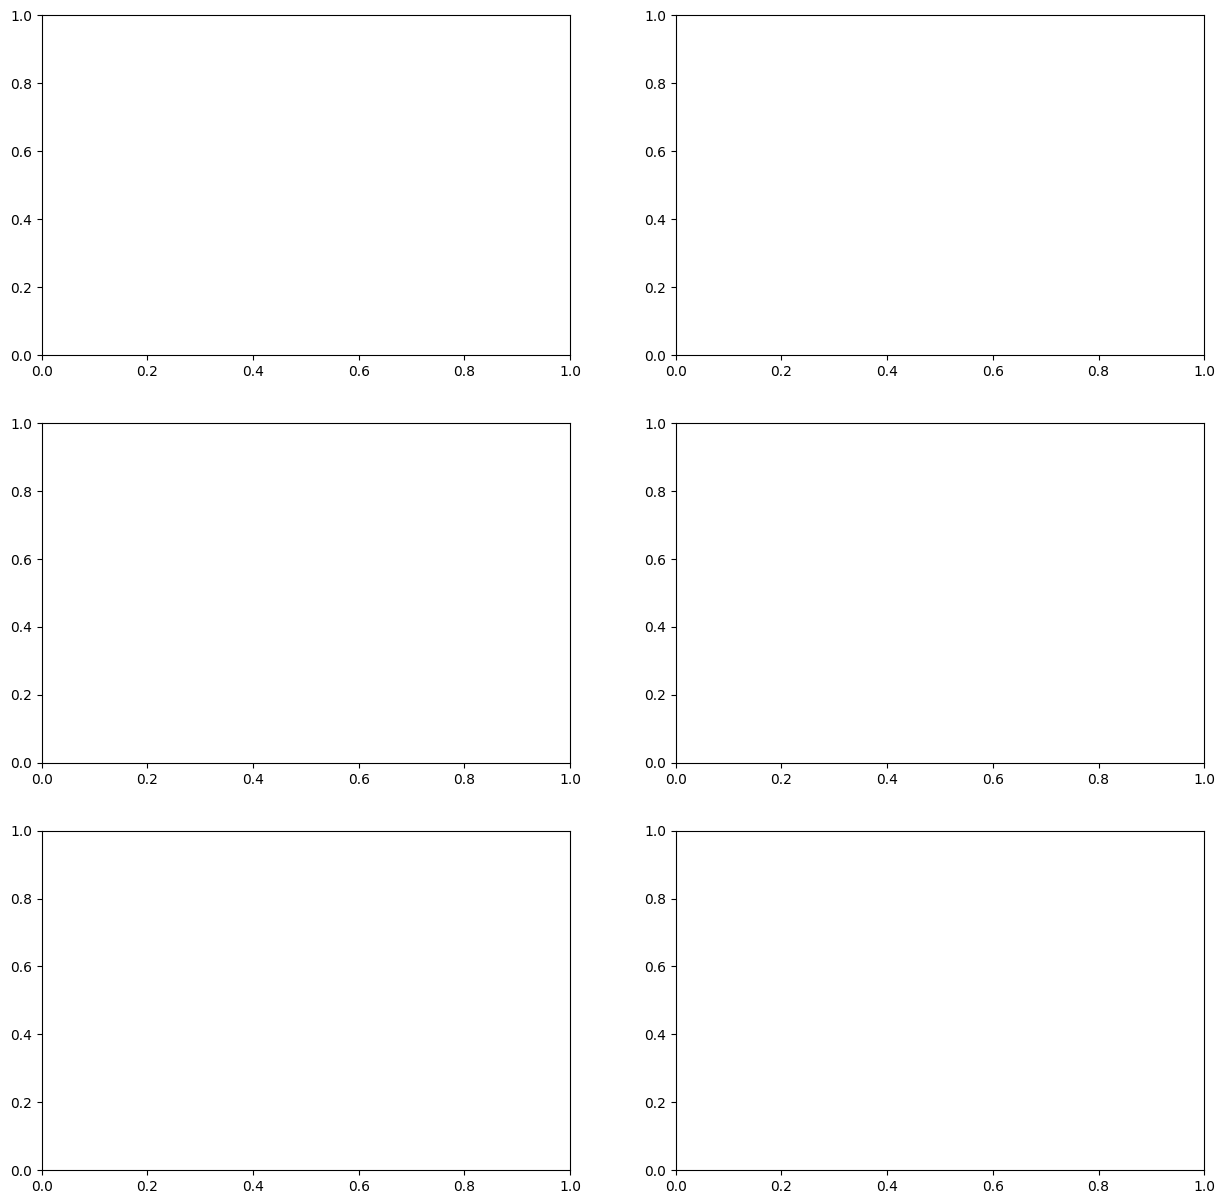

In [ ]:
figure, axis = plt.subplots(3, 2)
figure.set_figheight(15)
figure.set_figwidth(15)

plot2d(r, w(r, 0), R, "r", "w(r,0)", "w(r,0)=0", axis[0, 0])
plot2d(r, partial_u_z(r, 0), R, "r", "∂u/∂z(r,0)", "∂u/∂z(r,0)=0", axis[0, 1])
plot2d(r, np.round(w(r, H), 9), R, "r", "w(r,H)", "w(r,H)=0", axis[1, 0])
plot2d(r, np.round(partial_u_z(r, H), 9), R, "r", "∂u/∂z(r,H)", "∂u/∂z(r,H)=0", axis[1, 1]) 
plot2d(z, np.round(u(R, z), 9), H, "r", "u(R,z)", "u(R,z)=0", axis[2, 0])
plot2d(z, np.round(partial_w_r(R, z), 9), H, "r", "∂w/∂r(R,z)", "∂w/∂r(R,z)=0", axis[2, 1])

## Plot solutions

In [ ]:
def plot3d(r, z, f, rlabel='r', zlabel='z', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim(r[0], r[-1])
    ax.set_ylim(z[0], z[-1])
    
    r3d, z3d = np.meshgrid(r, z)
    
    print(np.max(f(r3d, z3d)))

    ax.plot_surface(r3d, z3d, np.round(f(r3d, z3d), 9), cmap='viridis')

    ax.set_title(title)
    ax.set_xlabel(rlabel)
    ax.set_ylabel(zlabel)

8.322724506213548e-07


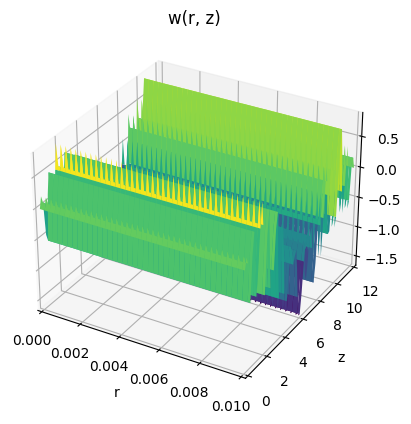

In [ ]:
plot3d(r, z, w, title="w(r, z)")

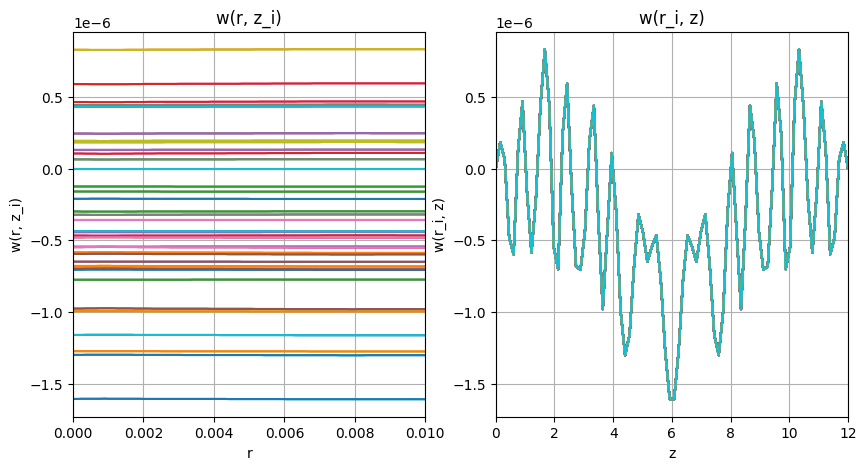

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(w(r, i), 9), R, "r", "w(r, z_i)", "w(r, z_i)", plot=axis[0])

for i in r:
    plot2d(z, np.round(w(i, z), 9), H, "z", "w(r_i, z)", "w(r_i, z)", plot=axis[1])

2.3398344074840406e-09


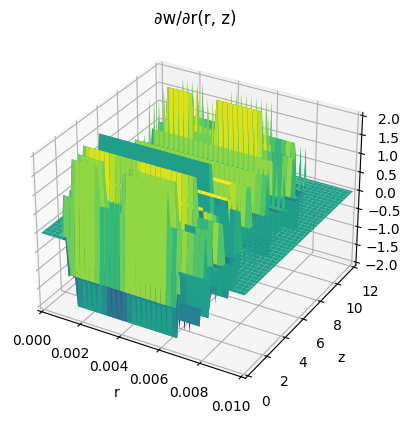

In [ ]:
plot3d(r, z, partial_w_r, title="∂w/∂r(r, z)")

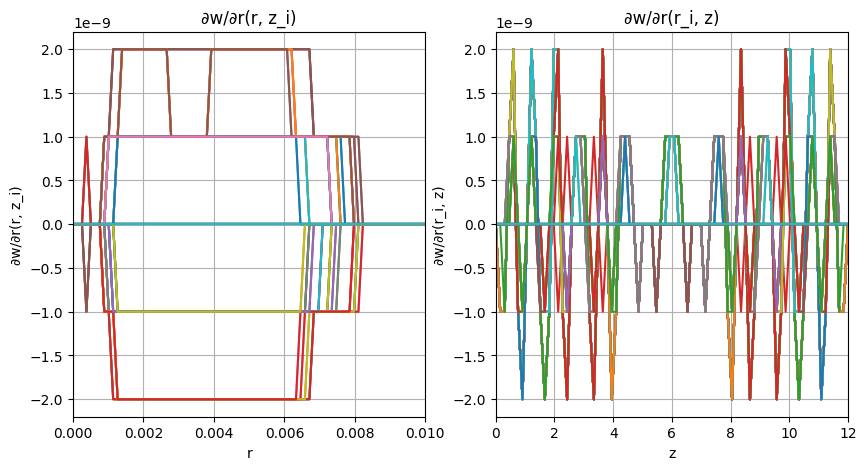

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(partial_w_r(r, i), 9), R, "r", "∂w/∂r(r, z_i)", "∂w/∂r(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(partial_w_r(i, z), 9), H, "z", "∂w/∂r(r_i, z)", "∂w/∂r(r_i, z)", plot=axis[1])

6.736719115633122e-06


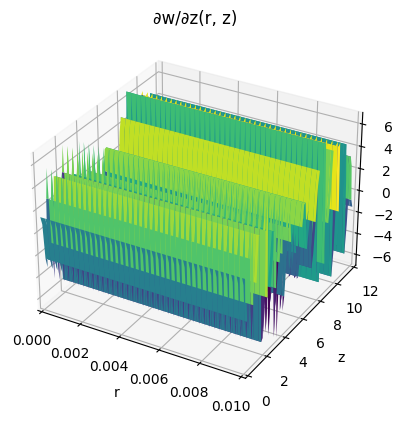

In [ ]:
plot3d(r, z, partial_w_z, title="∂w/∂z(r, z)")

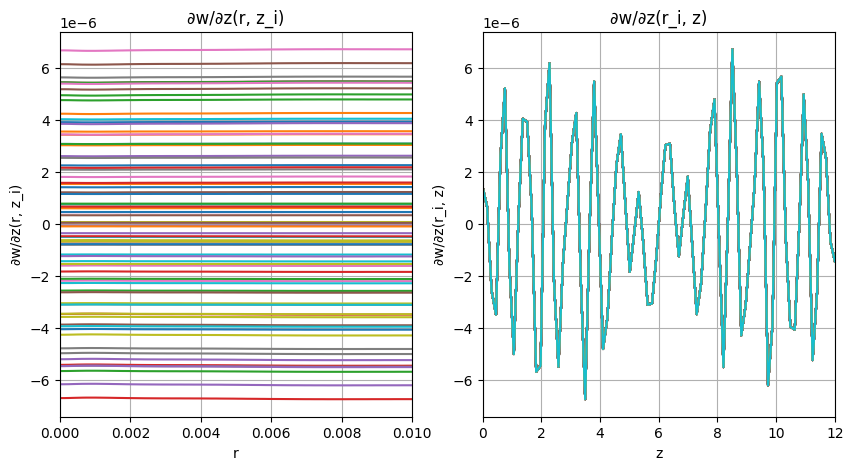

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(partial_w_z(r, i), 9), R, "r", "∂w/∂z(r, z_i)", "∂w/∂z(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(partial_w_z(i, z), 9), H, "z", "∂w/∂z(r_i, z)", "∂w/∂z(r_i, z)", plot=axis[1])

1.8779207585116875e-06


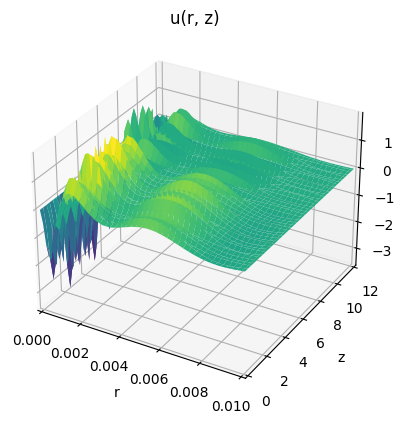

In [ ]:
plot3d(r, z, u, title="u(r, z)")

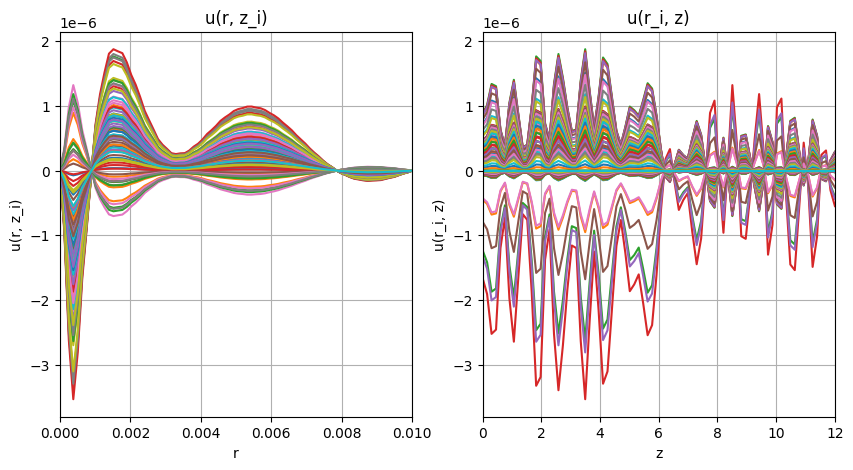

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(u(r, i), 9), R, "r", "u(r, z_i)", "u(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(u(i, z), 9), H, "z", "u(r_i, z)", "u(r_i, z)", plot=axis[1])

1.3432918643469003e-06


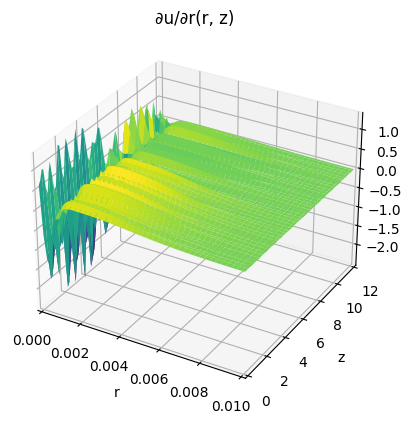

In [ ]:
plot3d(r, z, partial_u_r, title="∂u/∂r(r, z)")

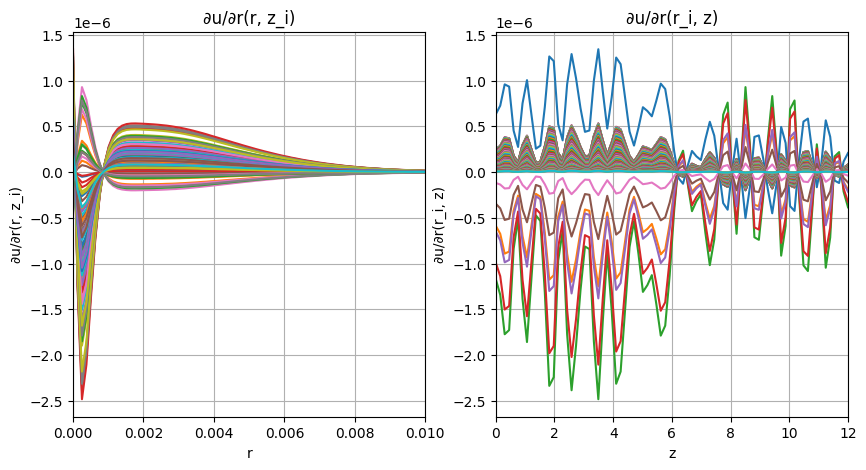

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(partial_u_r(r, i), 9), R, "r", "∂u/∂r(r, z_i)", "∂u/∂r(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(partial_u_r(i, z), 9), H, "z", "∂u/∂r(r_i, z)", "∂u/∂r(r_i, z)", plot=axis[1])

1.1295685066356486e-05


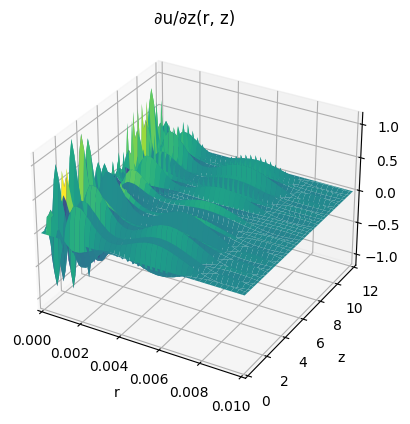

In [ ]:
plot3d(r, z, partial_u_z, title="∂u/∂z(r, z)")

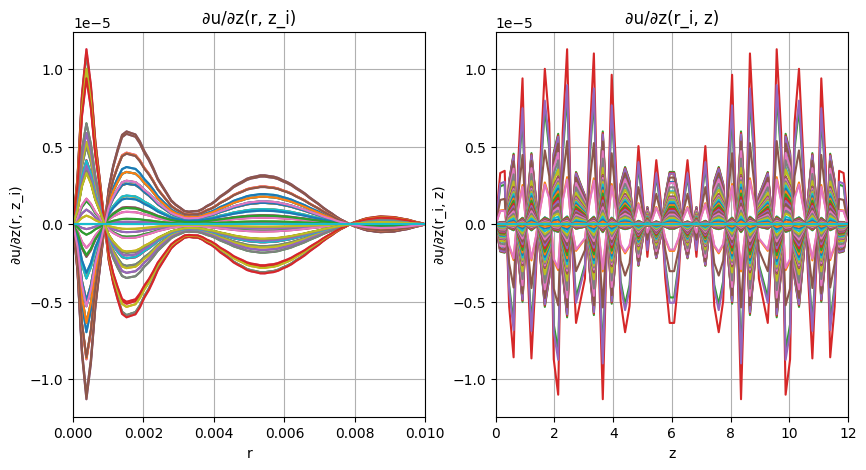

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(partial_u_z(r, i), 9), R, "r", "∂u/∂z(r, z_i)", "∂u/∂z(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(partial_u_z(i, z), 9), H, "z", "∂u/∂z(r_i, z)", "∂u/∂z(r_i, z)", plot=axis[1])

## Plot voltages functions

In [ ]:
r = r[1:]
z = z[1:]

0.4362613270633831


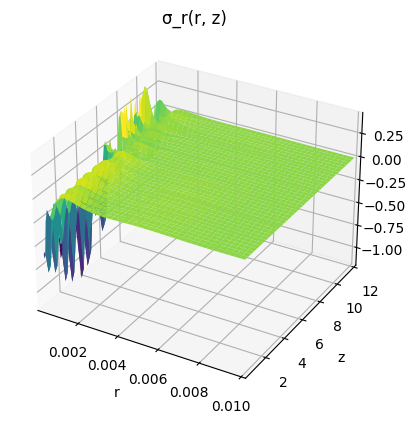

In [ ]:
plot3d(r, z, sigma_r, title="σ_r(r, z)")

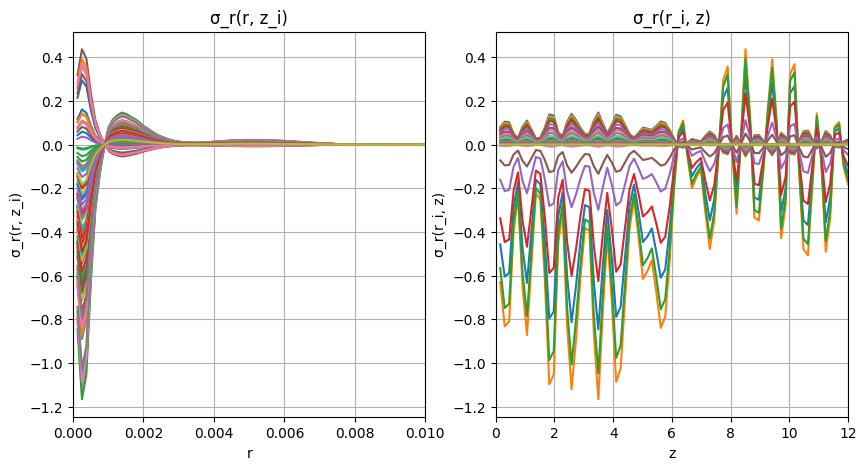

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

for i in z:
    plot2d(r, np.round(sigma_r(r, i), 9), R, "r", "σ_r(r, z_i)", "σ_r(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(sigma_r(i, z), 9), H, "z", "σ_r(r_i, z)", "σ_r(r_i, z)", plot=axis[1])

0.43712556852503837


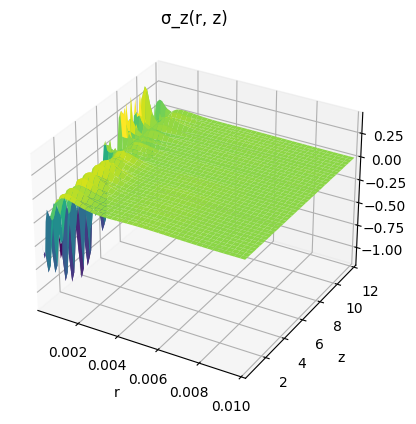

In [ ]:
plot3d(r, z, sigma_z, title="σ_z(r, z)")

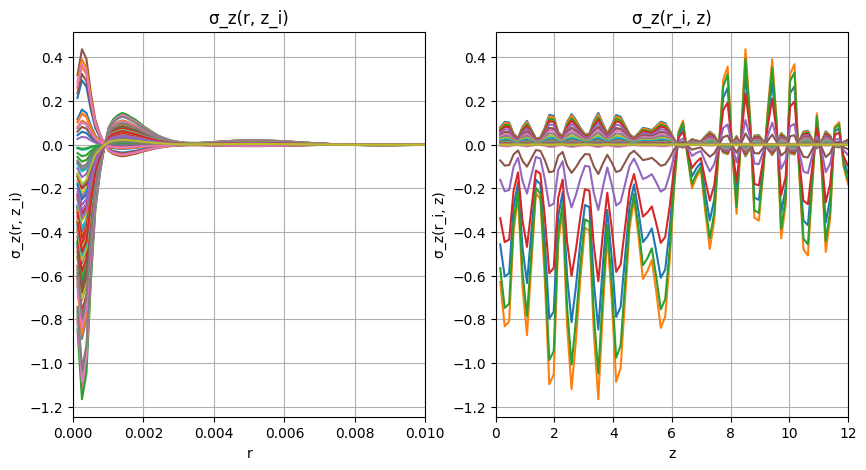

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

for i in z:
    plot2d(r, np.round(sigma_z(r, i), 9), R, "r", "σ_z(r, z_i)", "σ_z(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(sigma_z(i, z), 9), H, "z", "σ_z(r_i, z)", "σ_z(r_i, z)", plot=axis[1])

## Cylinder's visualization

In [ ]:
def draw_cylinder(colors=['red', 'blue', 'blue'] ,radius=1, height=2, resolution=30):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Генерация координат для боковой поверхности
    theta = np.linspace(0, 2 * np.pi, resolution)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    z_bottom = np.zeros_like(x)
    z_top = np.ones_like(x) * height
    
    # Рисуем боковую поверхность
    for i in range(len(x) - 1):
        verts = [[(x[i], y[i], z_bottom[i]),
                  (x[i+1], y[i+1], z_bottom[i+1]),
                  (x[i+1], y[i+1], z_top[i+1]),
                  (x[i], y[i], z_top[i])]]
        ax.add_collection3d(Poly3DCollection(verts, color=colors[0], edgecolor='k'))
    
    # Рисуем верхнюю и нижнюю крышки
    ax.add_collection3d(Poly3DCollection([list(zip(x, y, z_bottom))], color=colors[1], edgecolor='k'))
    ax.add_collection3d(Poly3DCollection([list(zip(x, y, z_top))], color=colors[2], edgecolor='k'))
    
    # Настройки осей
    ax.set_xlim([-radius, radius])
    ax.set_ylim([-radius, radius])
    ax.set_zlim([0, height])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([1, 1, height / radius])
    
    plt.show()

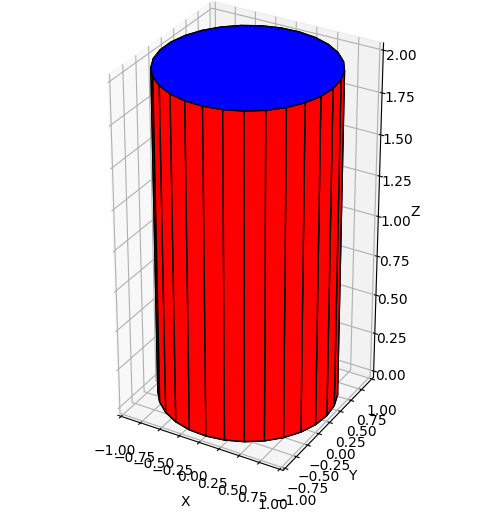

In [ ]:
draw_cylinder()

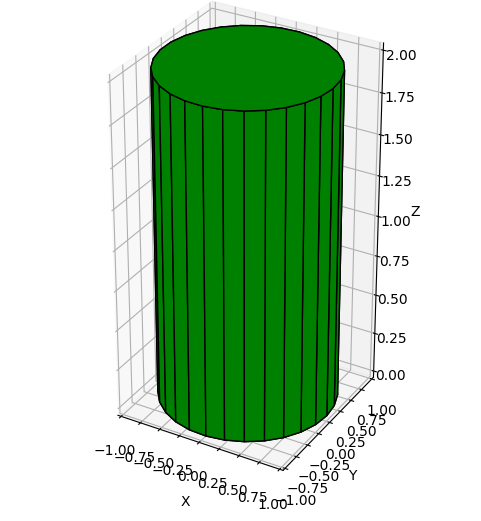

In [ ]:
draw_cylinder(['green', 'green', 'green'])

In [ ]:
def draw_pol_cylinder(outer_radius=1, inner_radius=0.7, height=2, resolution=30):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Генерация координат для внешней и внутренней боковых поверхностей
    theta = np.linspace(0, 2 * np.pi, resolution)
    outer_x = outer_radius * np.cos(theta)
    outer_y = outer_radius * np.sin(theta)
    inner_x = inner_radius * np.cos(theta)
    inner_y = inner_radius * np.sin(theta)
    z_bottom = np.zeros_like(outer_x)
    z_top = np.ones_like(outer_x) * height
    
    # Рисуем внешнюю боковую поверхность
    for i in range(len(outer_x) - 1):
        verts = [[(outer_x[i], outer_y[i], z_bottom[i]),
                  (outer_x[i+1], outer_y[i+1], z_bottom[i+1]),
                  (outer_x[i+1], outer_y[i+1], z_top[i+1]),
                  (outer_x[i], outer_y[i], z_top[i])]]
        ax.add_collection3d(Poly3DCollection(verts, color='green', edgecolor='k'))
    
    # Рисуем внутреннюю боковую поверхность
    for i in range(len(inner_x) - 1):
        verts = [[(inner_x[i], inner_y[i], z_bottom[i]),
                  (inner_x[i+1], inner_y[i+1], z_bottom[i+1]),
                  (inner_x[i+1], inner_y[i+1], z_top[i+1]),
                  (inner_x[i], inner_y[i], z_top[i])]]
        ax.add_collection3d(Poly3DCollection(verts, color='green', edgecolor='k'))
    
    # Рисуем верхнюю и нижнюю крышки как кольца
    ax.add_collection3d(Poly3DCollection([list(zip(outer_x, outer_y, z_bottom)) + list(zip(inner_x[::-1], inner_y[::-1], z_bottom))], color='green', edgecolor='k'))
    ax.add_collection3d(Poly3DCollection([list(zip(outer_x, outer_y, z_top)) + list(zip(inner_x[::-1], inner_y[::-1], z_top))], color='green', edgecolor='k'))
    
    # Настройки осей
    ax.set_xlim([-outer_radius, outer_radius])
    ax.set_ylim([-outer_radius, outer_radius])
    ax.set_zlim([0, height])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([1, 1, height / outer_radius])
    
    plt.show()


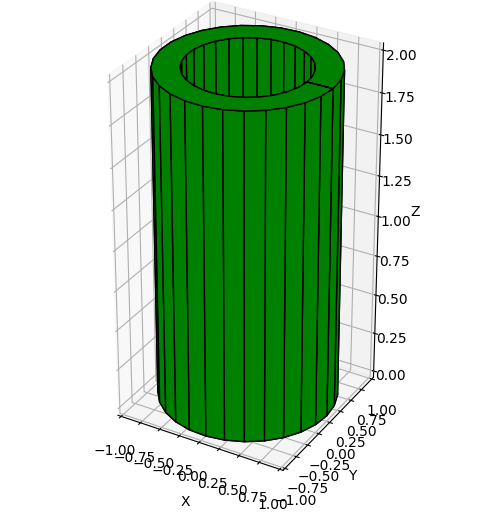

In [ ]:
draw_pol_cylinder()